Analysing the effect of GDP on the social movements in the USA

In [14]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# Connect to the database
gdp_db_path = '../../data/processed/social_movements.db'
conn = sqlite3.connect(gdp_db_path)

# Query GDP data for the years 2010-2019 from the FRED table
query_gdp_2010s = """
SELECT 
    SUBSTR(Date, 1, 4) AS Year, 
    GDP_Billions
FROM FRED
WHERE Date LIKE '201%' 
ORDER BY Year;
"""
gdp_data = pd.read_sql_query(query_gdp_2010s, conn)

# Convert GDP year to integer and handle missing data
gdp_data['Year'] = gdp_data['Year'].astype(int)

# Display the retrieved GDP data
print(gdp_data)

# Close the database connection
conn.close()


   Year  GDP_Billions
0  2010     16789.750
1  2011     17052.410
2  2012     17442.759
3  2013     17812.167
4  2014     18261.714
5  2015     18799.622
6  2016     19141.672
7  2017     19612.102
8  2018     20193.896
9  2019     20715.671


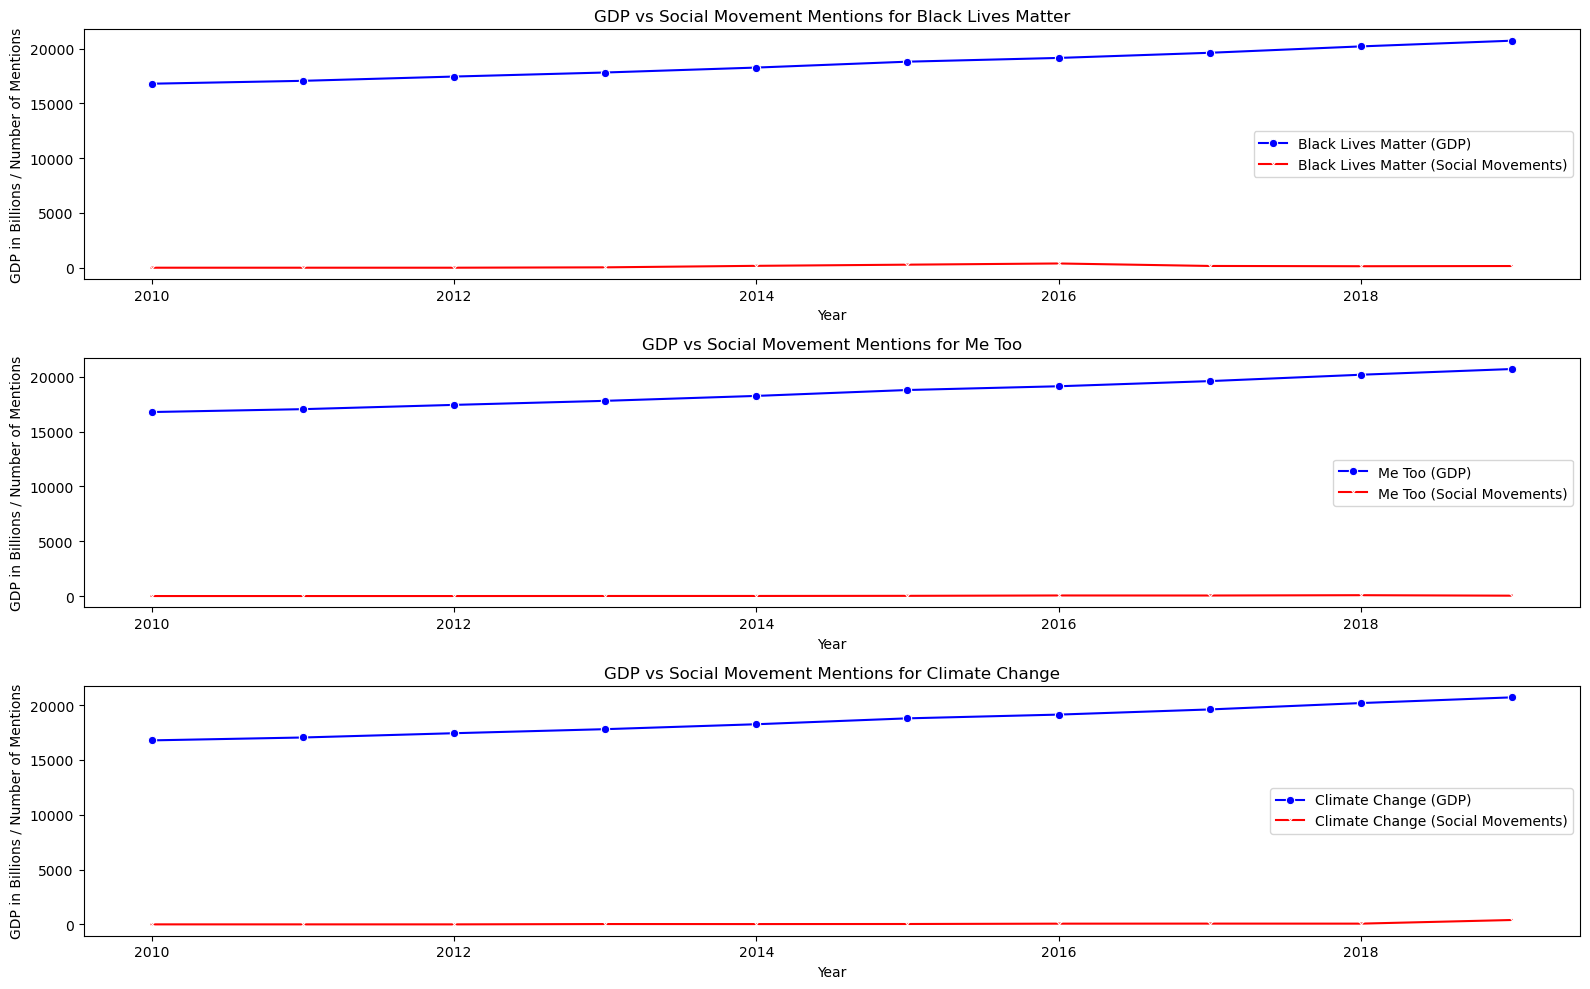

In [16]:


# Database connections
gdp_db_path = '../../data/processed/social_movements.db'
conn = sqlite3.connect(gdp_db_path)

# Predefined keywords for social movements
social_movements_keywords = {
    'Black Lives Matter': ['black', 'racial', 'civil-rights', 'blm'],
    'Me Too': ['gender', 'metoo', 'sexual-abuse', 'harassment'],
    'Climate Change': ['climate', 'global-warming', 'environmental', 'sustainability']
}

# Query GDP data for the years 2010-2019
query_gdp_2010s = """
SELECT 
    SUBSTR(Date, 1, 4) AS Year, 
    GDP_Billions
FROM FRED
WHERE Date LIKE '201%' 
ORDER BY Year;
"""
gdp_data = pd.read_sql_query(query_gdp_2010s, conn)

# Convert GDP year to integer and handle missing data
gdp_data['Year'] = gdp_data['Year'].astype(int)
gdp_data = gdp_data.set_index('Year')

# Query social movement mentions from the database for 2010-2019
movement_data = {}
for movement, terms in social_movements_keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions
    FROM SocialMovements
    WHERE ({term_conditions}) AND Date LIKE '201%'
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)
    movement_data[movement]['Year'] = movement_data[movement]['Year'].astype(int)

# Visualization: GDP vs Social Movements Mentions
plt.figure(figsize=(16, 10))

for i, movement in enumerate(social_movements_keywords.keys(), 1):
    plt.subplot(3, 1, i)

    # Merge GDP and social movement data
    combined_data = pd.merge(
        gdp_data[['GDP_Billions']], 
        movement_data[movement], 
        on='Year', 
        how='outer'
    ).fillna(0)

    # Plot the trends for GDP and Social Movements
    sns.lineplot(data=combined_data, x='Year', y='GDP_Billions', label=f'{movement} (GDP)', marker='o', color='blue')
    sns.lineplot(data=combined_data, x='Year', y='TotalMentions', label=f'{movement} (Social Movements)', marker='x', color='red')

    plt.title(f'GDP vs Social Movement Mentions for {movement}')
    plt.xlabel('Year')
    plt.ylabel('GDP in Billions / Number of Mentions')
    plt.legend()

plt.tight_layout()
plt.show()

# Close the database connection
conn.close()


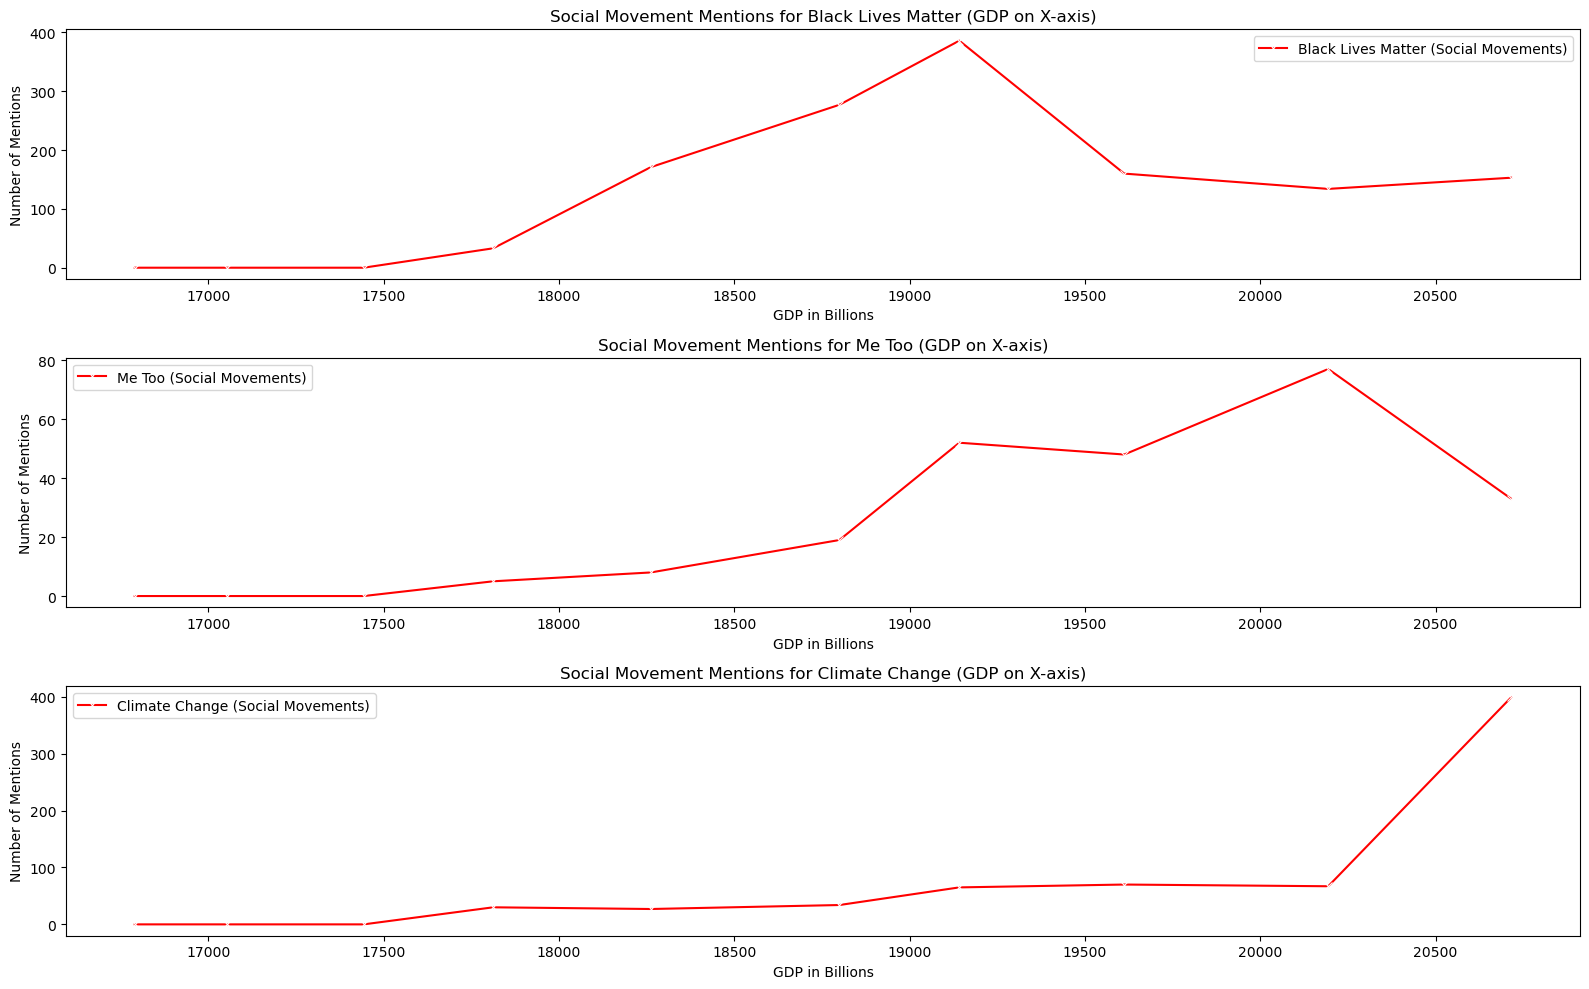

In [17]:

# Database connections
gdp_db_path = '../../data/processed/social_movements.db'
conn = sqlite3.connect(gdp_db_path)

# Predefined keywords for social movements
social_movements_keywords = {
    'Black Lives Matter': ['black', 'racial', 'civil-rights', 'blm'],
    'Me Too': ['gender', 'metoo', 'sexual-abuse', 'harassment'],
    'Climate Change': ['climate', 'global-warming', 'environmental', 'sustainability']
}

# Query GDP data for the years 2010-2019 from the FRED table
query_gdp_2010s = """
SELECT 
    SUBSTR(Date, 1, 4) AS Year, 
    GDP_Billions
FROM FRED
WHERE Date LIKE '201%' 
ORDER BY Year;
"""
gdp_data = pd.read_sql_query(query_gdp_2010s, conn)

# Convert GDP year to integer
gdp_data['Year'] = gdp_data['Year'].astype(int)

# Query themes from the 2010s
query_2010s_art = """
SELECT 
    Topics AS Theme,
    ProductionYear AS Year
FROM SmithsonianArtworks
WHERE ProductionYear IS NOT NULL 
AND LENGTH(ProductionYear) = 4 
AND CAST(ProductionYear AS INTEGER) BETWEEN 2010 AND 2019;
"""
art_data_2010s = pd.read_sql_query(query_2010s_art, conn)

# Split themes by comma and explode the DataFrame
art_data_2010s['Theme'] = art_data_2010s['Theme'].str.split(", ")
art_data_2010s = art_data_2010s.explode('Theme').dropna()

# Filter art themes by social movement keywords
movement_art_counts = {}
for movement, keywords in social_movements_keywords.items():
    condition = art_data_2010s['Theme'].str.contains('|'.join(keywords), case=False, na=False)
    filtered_art = art_data_2010s[condition]
    yearly_counts = filtered_art.groupby('Year').size().reset_index(name='ArtMentions')
    movement_art_counts[movement] = yearly_counts

# Query social movement mentions from the database
movement_data = {}
for movement, terms in social_movements_keywords.items():
    term_conditions = " OR ".join([f"SOURCEURL LIKE '%{term}%'" for term in terms])
    query = f"""
    SELECT 
        SUBSTR(Date, 1, 4) AS Year, 
        COUNT(*) AS TotalMentions
    FROM SocialMovements
    WHERE ({term_conditions}) AND Date LIKE '201%'
    GROUP BY Year
    ORDER BY Year;
    """
    movement_data[movement] = pd.read_sql_query(query, conn)

# Convert Year column in movement_data and movement_art_counts to integer for consistency
for movement in movement_art_counts:
    movement_art_counts[movement]['Year'] = movement_art_counts[movement]['Year'].astype(int)

for movement in movement_data:
    movement_data[movement]['Year'] = movement_data[movement]['Year'].astype(int)

# Visualization: Art Themes vs Social Movements with GDP on X-axis
plt.figure(figsize=(16, 10))

for i, movement in enumerate(social_movements_keywords.keys(), 1):
    plt.subplot(3, 1, i)

    # Merge art and social movement data with GDP data
    art_data_merged = pd.merge(
        movement_art_counts[movement], 
        movement_data[movement], 
        on='Year', 
        how='outer'
    ).fillna(0)

    # Merge with GDP data
    combined_data = pd.merge(
        art_data_merged,
        gdp_data[['Year', 'GDP_Billions']],
        on='Year',
        how='outer'
    ).fillna(0)

    # Plot only the social movement data (red line)
    sns.lineplot(data=combined_data, x='GDP_Billions', y='TotalMentions', label=f'{movement} (Social Movements)', marker='x', color='red')

    plt.title(f'Social Movement Mentions for {movement} (GDP on X-axis)')
    plt.xlabel('GDP in Billions')
    plt.ylabel('Number of Mentions')
    plt.legend()

# Save the figure as an SVG file
svg_file_path = "social_movements_vs_gdp.svg" 
plt.savefig(svg_file_path, format='svg')

plt.tight_layout()
plt.show()


# Close the database connection
conn.close()


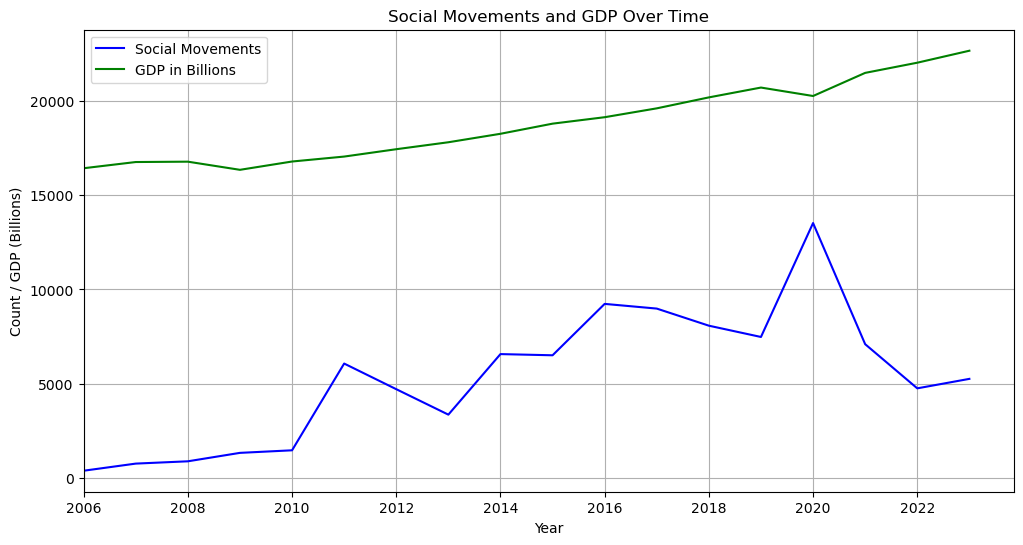

In [27]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to the SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDELT and GDP data
gdelt_query = "SELECT Date, PrimaryActor, SecondaryActor FROM SocialMovements"
gdp_query = "SELECT Date, GDP_Billions FROM FRED"  # Assuming GDP data is in this table and column

gdelt_df = pd.read_sql_query(gdelt_query, conn)
gdp_df = pd.read_sql_query(gdp_query, conn)

# Ensure date columns are in datetime format
gdelt_df["Date"] = pd.to_datetime(gdelt_df["Date"], errors='coerce')
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')

# Drop rows with missing dates
gdelt_df.dropna(subset=["Date"], inplace=True)
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract year for aggregation
gdelt_df["Year"] = gdelt_df["Date"].dt.year
gdp_df["Year"] = gdp_df["Date"].dt.year

# Merge GDP and GDELT datasets on Year
merged_df = pd.merge(gdelt_df, gdp_df, on="Year", how="inner")

# Count the number of social movement mentions per year
social_movement_counts = gdelt_df.groupby("Year").size().reset_index(name="SocialMovementCount")
gdp_counts = gdp_df.groupby("Year")["GDP_Billions"].first().reset_index(name="GDP_Billions")

# Merge the counts for plotting
counts_df = pd.merge(social_movement_counts, gdp_counts, on="Year", how="inner")

# Plot social movements vs. GDP over time
plt.figure(figsize=(12, 6))
plt.plot(counts_df["Year"], counts_df["SocialMovementCount"], label="Social Movements", color="blue")
plt.plot(counts_df["Year"], counts_df["GDP_Billions"], label="GDP in Billions", color="green")
plt.title("Social Movements and GDP Over Time")
plt.xlabel("Year")
plt.ylabel("Count / GDP (Billions)")
plt.legend()  # Ensure legend is shown
plt.grid(True)

# Set x-axis to start at 2006 and use a 2-year interval
plt.xlim(left=2006)
plt.xticks(np.arange(2006, counts_df["Year"].max() + 1, 2))  # 2-year interval on x-axis

svg_file_path = "social_movements_gdp_per_year.svg" 
plt.savefig(svg_file_path, format='svg')

plt.show()

conn.close()


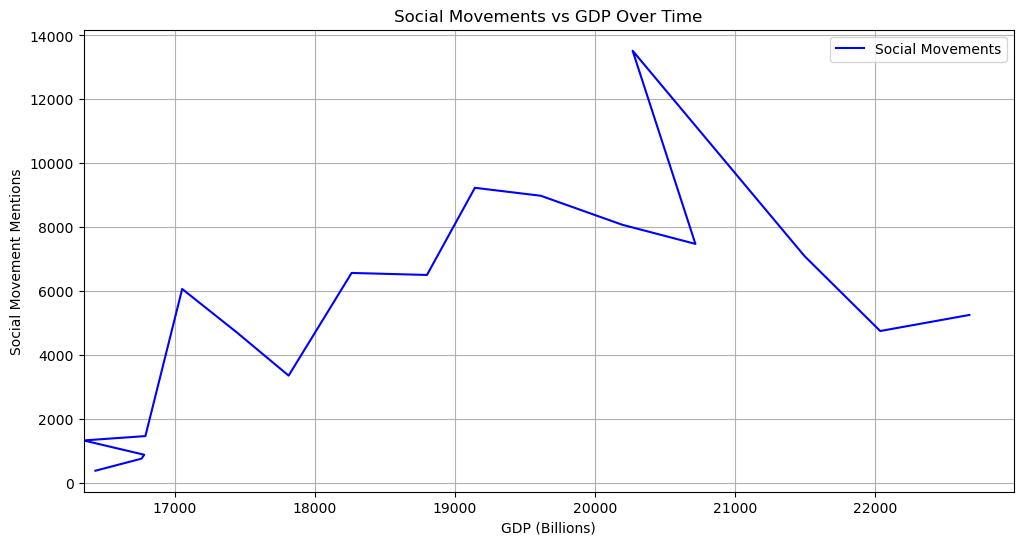

In [30]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to the SQLite database
db_path = "../../data/processed/social_movements.db"
conn = sqlite3.connect(db_path)

# Query GDELT and GDP data
gdelt_query = "SELECT Date, PrimaryActor, SecondaryActor FROM SocialMovements"
gdp_query = "SELECT Date, GDP_Billions FROM FRED"  # Assuming GDP data is in this table and column

gdelt_df = pd.read_sql_query(gdelt_query, conn)
gdp_df = pd.read_sql_query(gdp_query, conn)

# Ensure date columns are in datetime format
gdelt_df["Date"] = pd.to_datetime(gdelt_df["Date"], errors='coerce')
gdp_df["Date"] = pd.to_datetime(gdp_df["Date"], errors='coerce')

# Drop rows with missing dates
gdelt_df.dropna(subset=["Date"], inplace=True)
gdp_df.dropna(subset=["Date"], inplace=True)

# Extract year for aggregation
gdelt_df["Year"] = gdelt_df["Date"].dt.year
gdp_df["Year"] = gdp_df["Date"].dt.year

# Merge GDP and GDELT datasets on Year
merged_df = pd.merge(gdelt_df, gdp_df, on="Year", how="inner")

# Count the number of social movement mentions per year
social_movement_counts = gdelt_df.groupby("Year").size().reset_index(name="SocialMovementCount")
gdp_counts = gdp_df.groupby("Year")["GDP_Billions"].first().reset_index(name="GDP_Billions")

# Merge the counts for plotting
counts_df = pd.merge(social_movement_counts, gdp_counts, on="Year", how="inner")

# Plot social movements vs. GDP (GDP on x-axis)
plt.figure(figsize=(12, 6))
plt.plot(counts_df["GDP_Billions"], counts_df["SocialMovementCount"], label="Social Movements", color="blue")
plt.title("Social Movements vs GDP Over Time")
plt.xlabel("GDP (Billions)")
plt.ylabel("Social Movement Mentions")
plt.legend()  # Ensure legend is shown
plt.grid(True)

# Set x-axis to start from minimum GDP value
plt.xlim(left=counts_df["GDP_Billions"].min())

svg_file_path = "social_movements_gdp_overtime.svg" 
plt.savefig(svg_file_path, format='svg')

plt.show()

conn.close()
